# Running LLMs in the Cloud

> Creating an LLM environment for Fine-Tuning in a cloud GPU.

There are many companies that offer GPUs in the Cloud. In this Notebook we choose Paperspace for its mix of ease and options.  


First, let's go over some cloud providers that cover different use-cases and options:   
- Lambda Labs.   
- Paperspace.  
- Google Colab. 


[Lambda Labs](https://lambdalabs.com/) is a very popular GPU cloud provider. It has great pricing. Unfortunately, its combo of popularity and low costs means that GPUs are often claimed and we're not guaranteed to get one. Making an account and launching GPUs, when they *are* open, is incredibly fast and straightforward.  

[Paperspace](https://www.paperspace.com/) offers cloud GPUs in two different, complementary ways. Their platform called Gradient is built around Notebooks and is tailored for quick ML and scientific jobs. Their CORE service, on the other hand, has more low-level options. We use it to fully customize and deploy a VM with a GPU. Paperspace tends to have better availability than Lambda Labs.    

[Colab](https://colab.google/) is an option provided by Google. It builds around their own flavor of Notebooks that is very similar to Jupyter's. One of Colab's most useful features is the ability to directly load a Notebook straight from any of your Git repos. It's a convenient and flexible option without the overhead of Lambda or Paperspace.   


> Note: the cloud GPU scene changes fast. The points above are rules of thumb, specifics change all of the time.

## Launching a GPU VM with Paperspace

We use Paperspace because it lets us deploy custom VMs in different ways.

[Sign up](https://console.paperspace.com/signup) for a Paperspace account or log in if you already have one. After logging in, you should land at a similar page to this one:

![](imgs/paperspace_startup.png)

The `Create a Machine` button on the top-left takes us to the page for setting up and deploying VMs.

One of the first options is picking the OS on the VM. We use Ubuntu 22.04 to leverage its latest updates and improvements.

![](imgs/paperspace_os_choice.png)

Next we pick the OS that the VM will run. The screenshot below shows the `Quadro M4000` GPU which is the cheapest option at $0.45 an hour. 

![](imgs/paperspace_gpu_choice.png)

It's good to keep the cost of running these cloud VMs in mind, so we don't get any billing surprises. Below we do some quick math to see the costs of running this GPU:

In [1]:
# price of an hour for the Quadro M4000 GPU
price_per_hour = 0.45

# leaving the machine on for a day
day_cost = 24 * price_per_hour

# leaving it on for a week
week_cost = 7 * day_cost

# leaving it up for a month
month_cost = 4 * week_cost

print(f"""
Quadro M4000 Costs:
Hour:  ${price_per_hour:.2f}
Day:   ${day_cost:.2f}
Week:  ${week_cost:.2f}
Month: ${month_cost:.2f}
""")


Quadro M4000 Costs:
Hour:  $0.45
Day:   $10.80
Week:  $75.60
Month: $302.40



Leaving it on for a full day isn't too bad. But the cost rises quickly the longer we leave on the machine. This is even worse with the more expensive GPU cards. Thankfully, the fine-tuning we'll be doing should fit well within a day. 

### VM's connection to the outside world

Next we get to pick how to connect to this VM from a local computer: 
![](imgs/paperspace_vm_connect_opts.png)

In this case we pick the [`ssh`](https://arjunaravind.in/blog/learning-and-using-ssh/) option.

Some of you likely have keys already in `~/.ssh`. If not, here are two good tutorial options for SSH setups. The first is this [Lambda Labs SSH tutorial](https://lambdalabs.com/blog/getting-started-with-lambda-cloud-gpu-instances). The second is a video from Paperspace embedded below.

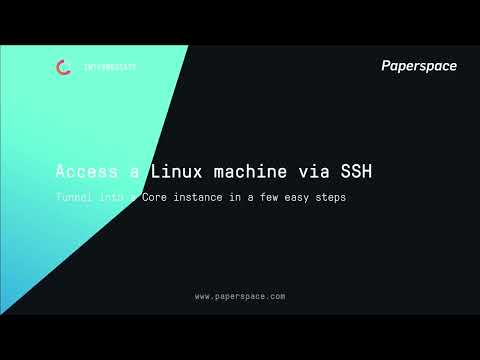

In [4]:
#| hide
# embedding Paperspace's youtube ssh tutorial directly in a Notebook
from IPython.display import YouTubeVideo
YouTubeVideo('3E_C4H8XSGg', width=700, height=400)


Once you have your key, add it under the `SSH Keys` section of your Paperspace account before going forward:

![](imgs/paperspace_ssh_key.png)

We're almost done setting up the VM. Back at the bottom of the creation page, Paperspace summarizes the VM configuration and its cost. If the summary looks good, go ahead and click the `Create` button to deploy the cloud VM.

![](imgs/paperspace_cost_summary.png)

Start the machine by clicking `Connect` from the main page:

![](imgs/paperspace_machine_page.png)

Once we connect to the machine, we need to install the nvidia drivers. This is the software that lets our Machine Learning algorithms take full advantage of the GPU.

Here is an [excellent and clear guide](https://gist.github.com/denguir/b21aa66ae7fb1089655dd9de8351a202) to install the nvidia drivers.  

### Alternative to NVIDIA Driver Installation

Paperspace also offers a VM ready-to-go for Machine Learning applications. It's called `ML-In-A-Box` and includes the nvidia drivers. It's a great option if you want to get up and running quickly, or just want to skip the driver installation step (understandable).  

This pre-configured VM might not have the latest version of the drivers, but we can always fix that later.

Here is a screenshot with both types of Machines: custom and `ML-In-A-Box`:
![](imgs/paperspace_both_types.png)

## Creating the `llm_base` environment in the VM

For this example we'll use the `ML-In-A-Box` VM. But, the steps are roughly the same for the custom VM, after installing the nvidia drivers.   

The steps below are mostly repeated from the first lesson on creating the Environment. The two main changes:  
- The requirements are pip-installed in a different order than on Mac.   
- We can now install the libraries in `reqs_optim.txt` to speed up the LLMs.    

```bash
## Setting up the Environment on a VM

# connect to the Paperspace VM
ssh paperspace@some-ip-here

# install mamba
curl -L -O "https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh"
bash Miniforge3-$(uname)-$(uname -m).sh
# NOTE: after installing mamba, refresh your terminal

# clone the course repo
git clone https://github.com/enzokro/Fractal-LLM-Course.git

# move in to the environment folder
cd Fractal-LLM-Course/Fractal_LLM_Course/lesson_0/envs

# create the base environment
mamba env create -f environment.yml

# activate the environment
mamba activate llm_base

# install the pytorch library
python -m pip install -r reqs_torch.txt

# install the python packages, after activating the env
python -m pip install -r requirements.txt  

# now, we can also install the extra packages to speed up LLMs
python -m pip install -r reqs_optim.txt  
```

### Checking if we can use the GPU

Drum roll... moment of truth. Can we actually use the GPU with pytorch? Run the following python code in the terminal to find out:

```python
## first, make sure the `llm_base` environment is active
## then, run the following python code in a shell

# import the torch library
import torch

# check if we can see the GPU
print(torch.cuda.is_available()) # should print "True"
```  

If the above command shows `True`, we're good to go! We now have the `llm_base` environment on a cloud VM with a working GPU.

### Tying this approach to Fine-Tuning

Eventually, we'll reserve a stronger GPU (or more of the weaker ones) with more memory and resources to handle the LLM fine-tuning. 

## Summary

This notebook covered how to launch and connect to a cloud GPU running on Paperspace. We then created the `llm_base` environment on the VM, mimicking our local environment. That means any notebook or command we've ran on our local computer can now run in the VM.

#### Aside(?): Going over CUDA driver install

> Recording the CUDA driver install process...

#### Aside(??): `llm_base` on Colab